In [219]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [220]:
import umap
from MODULES.vae_model import *
from MODULES.utilities_visualization import show_batch
from MODULES.utilities_ml import SpecialDataSet
from MODULES.utilities import load_json_as_dict

# Check versions
import torch
import numpy
from platform import python_version
print("python_version() ---> ", python_version())
print("torch.__version__ --> ", torch.__version__)

# make sure to fix the randomness at the very beginning
torch.manual_seed(0)
numpy.random.seed(0)

python_version() --->  3.8.2
torch.__version__ -->  1.6.0


## Get the test_datasets

In [221]:
img_test, seg_mask_test, count_test = load_obj("./NO_GRID_multi_mnist_test.pt")
test_loader_no_grid = SpecialDataSet(img=img_test,
                                     roi_mask=None,
                                     seg_mask=seg_mask_test,
                                     labels=count_test,
                                     batch_size=50,
                                     drop_last=False,
                                     shuffle=False)

img_test, seg_mask_test, count_test = load_obj("./DISCRETE_GRID_multi_mnist_test.pt")
test_loader_with_grid = SpecialDataSet(img=img_test,
                                       roi_mask=None,
                                       seg_mask=seg_mask_test,
                                       labels=count_test,
                                       batch_size=50,
                                       drop_last=False,
                                       shuffle=False)

## Get the trained models

In [222]:
params_no_grid = load_json_as_dict("./ML_parameters_NO_GRID.json")
vae_no_grid = CompositionalVae(params_no_grid)
ckpt_no_grid = file2ckpt(path="last_ckpt_NO_GRID.pt", device='cpu')
load_from_ckpt(ckpt=ckpt_no_grid,
               model=vae_no_grid,
               optimizer=None,
               overwrite_member_var=True)

params_with_grid = load_json_as_dict("./ML_parameters_WITH_GRID.json")
vae_with_grid = CompositionalVae(params_with_grid)
ckpt_with_grid = file2ckpt(path="last_ckpt_WITH_GRID.pt", device='cpu')
load_from_ckpt(ckpt=ckpt_with_grid,
               model=vae_with_grid,
               optimizer=None,
               overwrite_member_var=True)

## Find two example images 

In [223]:
index_tmp = torch.arange(test_loader_with_grid.img.shape[0])[:128]
tmp_imgs, tmp_seg, tmp_count = test_loader_with_grid.load(index=index_tmp)[:3]
mask = (tmp_count == 6) + (tmp_count == 5)
print(index_tmp[mask][:16])

index = torch.tensor([70, 71], dtype=torch.long)
ref_imgs_with_grid, ref_seg_with_grid, ref_count_with_grid = test_loader_with_grid.load(index=index)[:3]
ref_imgs_no_grid, ref_seg_no_grid, ref_count_no_grid = test_loader_no_grid.load(index=index)[:3]

tensor([ 7, 14, 18, 26, 28, 33, 40, 42, 49, 52, 57, 61, 64, 70, 71, 79])


## run inference

In [282]:
with torch.no_grad():
    output_no_grid = vae_no_grid.forward(ref_imgs_no_grid,
                                         overlap_threshold=0.5,
                                         noisy_sampling=True,
                                         draw_image=True,
                                         draw_boxes=True,
                                         draw_bg=True,
                                         verbose=False)
    
    
    output_with_grid = vae_with_grid.forward(ref_imgs_with_grid,
                                             overlap_threshold=0.5,
                                             noisy_sampling=True,
                                             draw_image=True,
                                             draw_boxes=True,
                                             draw_bg=True,
                                             verbose=False)
    
    segment_no_grid = vae_no_grid.segment(ref_imgs_no_grid,
                                          noisy_sampling=True,
                                          overlap_threshold=0.5)
    
    segment_with_grid = vae_with_grid.segment(ref_imgs_with_grid,
                                              noisy_sampling=True,
                                              overlap_threshold=0.5)

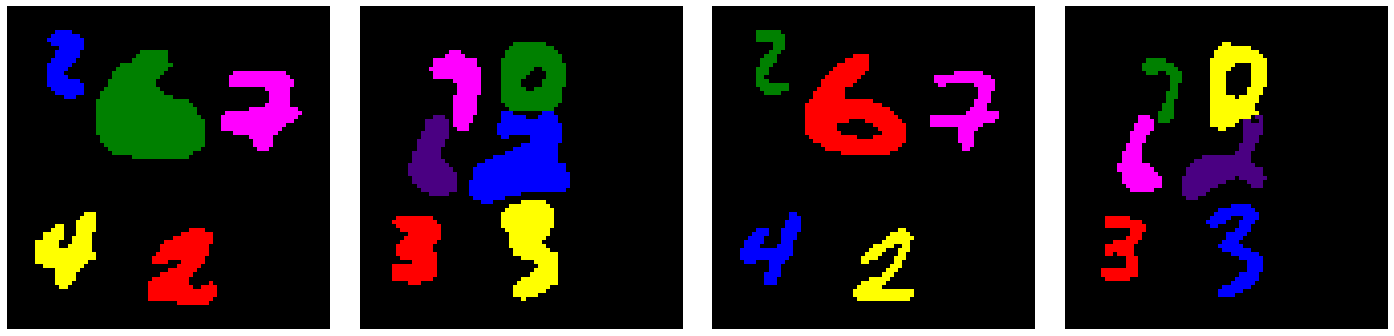

In [326]:
from torchvision import utils

seg_mask = torch.cat((segment_no_grid.integer_mask, segment_with_grid.integer_mask), dim=0).float()


fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for n in range(4):
    ax[n].imshow(skimage.color.label2rgb(seg_mask[n,0].numpy(), 
                                         bg_label=0, 
                                         image_alpha=1, kind='overlay'))
    ax[n].axis('off') 
fig.tight_layout(pad=3.0)
fig.savefig("./seg_mask.pdf")
fig.savefig("./seg_mask.png")

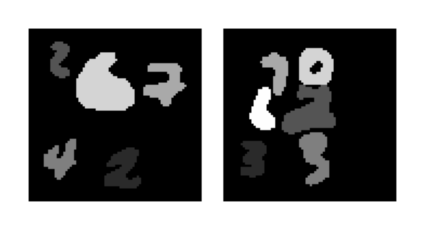

In [286]:
show_batch(segment_no_grid.integer_mask.float())

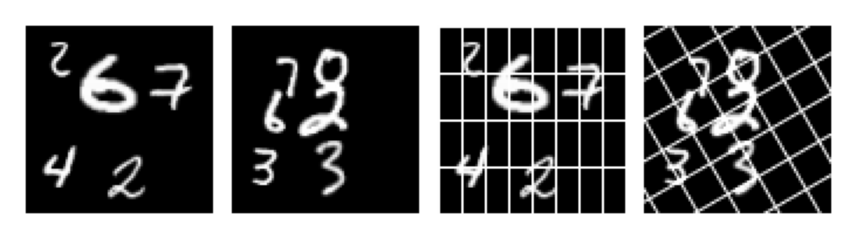

In [322]:
inputs = torch.cat((ref_imgs_no_grid, ref_imgs_with_grid), dim=0)
tmp = show_batch(inputs, n_col=4, n_padding=8, figsize=(12,12))
tmp.tight_layout()
tmp.savefig("./inputs.pdf", dpi=100)
tmp

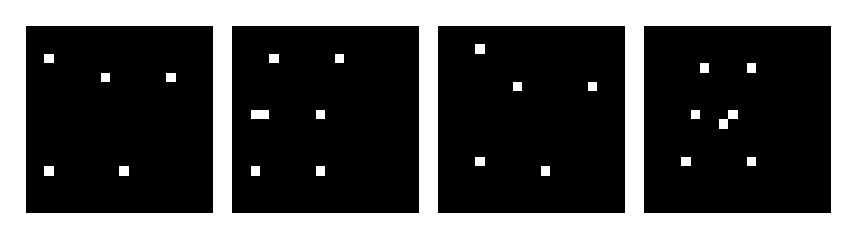

In [323]:
only_cgrid = torch.cat((output_no_grid.inference.sample_c_map_before_nms,
                        output_with_grid.inference.sample_c_map_before_nms), dim=0)
           
tmp = show_batch(only_cgrid, n_col=4, n_padding=2, figsize=(12,12))
tmp.tight_layout()
tmp.savefig("./only_cgrid.pdf", dpi=100)
tmp

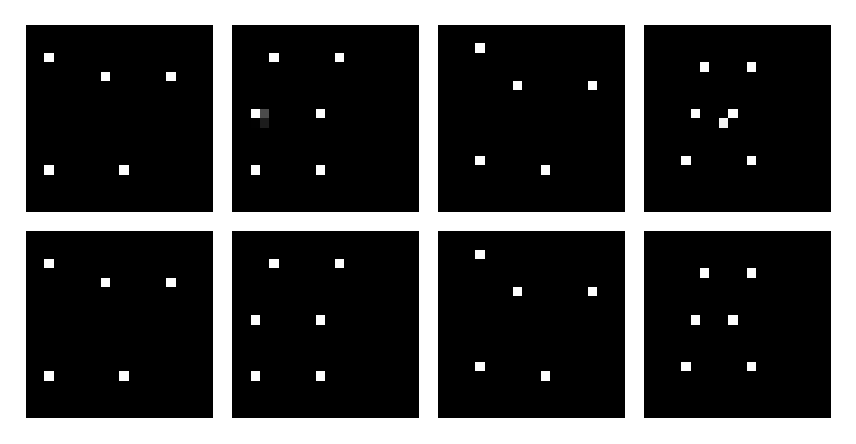

In [260]:
pgrid_and_cgrid = torch.cat((output_no_grid.inference.prob_map, 
                             output_with_grid.inference.prob_map,
                             output_no_grid.inference.sample_c_map_after_nms,
                             output_with_grid.inference.sample_c_map_after_nms), dim=0)
           
tmp = show_batch(pgrid_and_cgrid, n_col=4, n_padding=2, figsize=(12,12))
tmp.tight_layout()
tmp.savefig("./pgrid_and_cgrid.png", dpi=100)
tmp

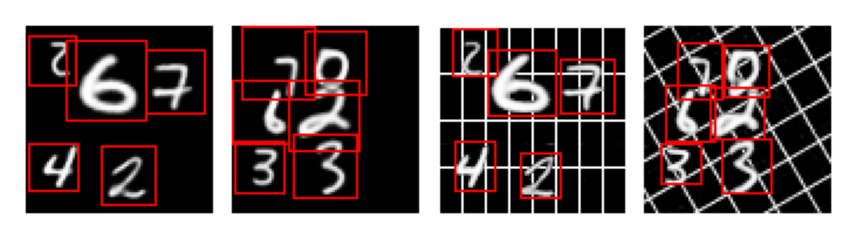

In [324]:
reconstruction = torch.cat((output_no_grid.imgs, output_with_grid.imgs), dim=0)
tmp = show_batch(reconstruction, n_col=4, n_padding=8, figsize=(12,12))
tmp.tight_layout()
tmp.savefig("./reconstruction.pdf", dpi=100)
tmp

# MAKE accuracy plots

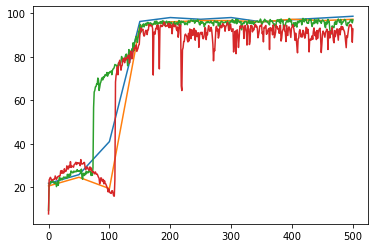

In [278]:
y_test_grid = 100*numpy.array(ckpt_with_grid["history_dict"]["test_accuracy"])
y_test_no_grid = 100*numpy.array(ckpt_no_grid["history_dict"]["test_accuracy"])
y_train_grid = 100*numpy.array(ckpt_with_grid["history_dict"]["train_accuracy"])
y_train_no_grid = 100*numpy.array(ckpt_no_grid["history_dict"]["train_accuracy"])

x_test_grid = numpy.arange(len(y_test_grid))*50
x_test_no_grid = numpy.arange(len(y_test_no_grid))*50
x_train_grid = numpy.arange(len(y_train_grid))
x_train_no_grid = numpy.arange(len(y_train_no_grid))

plt.plot(x_test_grid,y_test_grid)
plt.plot(x_test_no_grid,y_test_no_grid)
plt.plot(x_train_grid,y_train_grid)
plt.plot(x_train_no_grid,y_train_no_grid)

numpy.save("./x_train_no_grid", x_train_no_grid, allow_pickle=False)
numpy.save("./x_train_grid", x_train_grid, allow_pickle=False)
numpy.save("./x_test_no_grid", x_test_no_grid, allow_pickle=False)
numpy.save("./x_test_grid", x_test_grid, allow_pickle=False)
numpy.save("./y_train_no_grid", y_train_no_grid, allow_pickle=False)
numpy.save("./y_train_grid", y_train_grid, allow_pickle=False)
numpy.save("./y_test_no_grid", y_test_no_grid, allow_pickle=False)
numpy.save("./y_test_grid", y_test_grid, allow_pickle=False)

In [ ]:
numpy.save(""
    
    numpy.save(file, arr, allow_pickle=True
               
               

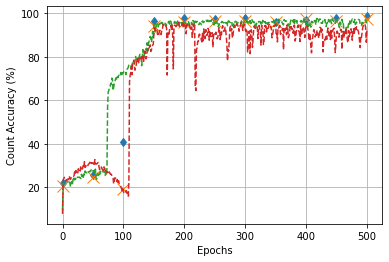

In [272]:
test_with_grid = 100*numpy.array(ckpt_with_grid["history_dict"]["test_accuracy"])
train_with_grid = 100*numpy.array(ckpt_with_grid["history_dict"]["train_accuracy"])
test_no_grid = 100*numpy.array(ckpt_no_grid["history_dict"]["test_accuracy"])
train_no_grid = 100*numpy.array(ckpt_no_grid["history_dict"]["train_accuracy"])



plt.plot(x_grid, test_with_grid, "d", markersize=6, label="test, with bg")
plt.plot(x_no_grid, test_no_grid, "x", markersize=12, label="test, no bg")
plt.plot(train_with_grid,"--", label="train, with bg")
plt.plot(train_no_grid,"--", label="train, no bg")
x_grid = numpy.arange(len(test_with_grid))*50
x_no_grid = numpy.arange(len(test_no_grid))*50
#plt.legend()
plt.grid()
#plt.tight_layout()
plt.xlabel("Epochs")
plt.ylabel("Count Accuracy (%)")
plt.savefig("./accuracy.png", dpi=100)





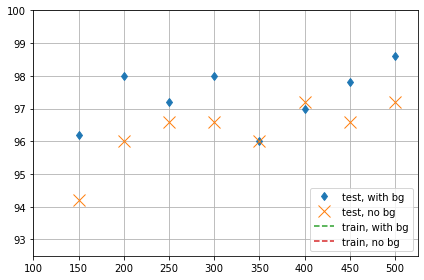

In [263]:
x_grid = numpy.arange(len(test_with_grid))*50
x_no_grid = numpy.arange(len(test_no_grid))*50
plt.plot(x_grid, test_with_grid, "d", markersize=6, label="test, with bg")
plt.plot(x_no_grid, test_no_grid, "x", markersize=12, label="test, no bg")
plt.plot(0*train_with_grid,"--", label="train, with bg")
plt.plot(0*train_no_grid,"--", label="train, no bg")
plt.grid()
plt.ylim(92.5,100)
plt.xlim(100)
plt.tight_layout()
plt.legend()
plt.savefig("./zoom_accuracy.png", dpi=100)

# Make UMAP

### Helper function get the digit_label from the segmentation mask and bounding_box

In [264]:
def get_digit_labels_from_seg_mask(seg_mask, bounding_box, c):
    labels = torch.zeros_like(bounding_box.bx)
    n_box, batch_size = bounding_box.bx.shape
    batch_size, ch, w, h = seg_mask.shape
    
    x1 = (bounding_box.bx - 0.5 * bounding_box.bw).long().clamp(min=0, max=w)
    x3 = (bounding_box.bx + 0.5 * bounding_box.bw).long().clamp(min=0, max=w)
    y1 = (bounding_box.by - 0.5 * bounding_box.bh).long().clamp(min=0, max=h)
    y3 = (bounding_box.by + 0.5 * bounding_box.bh).long().clamp(min=0, max=h)
    
    for batch in range(batch_size):
        for n in range(n_box):
            if c[n, batch] == 0:
                labels[n, batch] = -1
            else:
                tmp = seg_mask[batch,0,x1[n,batch]:x3[n,batch],y1[n,batch]:y3[n,batch]].clone()
                count = torch.bincount(tmp.view(-1))
                l = torch.argmax(count[1:], dim=0).item()
                labels[n, batch] = l
    return labels

def select_filled_boxes(z, digit_labels):
    z = z.flatten(end_dim=-2)
    digit_labels = digit_labels.flatten()
    mask = (digit_labels != -1)
    z_digit = z[mask,:]
    label_digit = digit_labels[mask]
    return z_digit, label_digit

def get_encoding(data_loader, model):
    n_imgs = data_loader.img.shape[0]
    n_boxes = model.input_img_dict["n_objects_max"] 
    n_latent = model.inference_and_generator.decoder_zinstance.dim_z
    print("n_boxes,n_imgs,n_latent ->", n_boxes,n_imgs,n_latent)

    z = torch.zeros((n_boxes,n_imgs,n_latent), dtype=torch.float)
    digit_labels = torch.zeros((n_boxes,n_imgs), dtype=torch.int)

    with torch.no_grad():
        n = 0
        for i, (imgs, seg_mask, l, index) in enumerate(test_loader_no_grid):
            dn = imgs.shape[0]
        
            output = model.forward(imgs_in=imgs,
                                   overlap_threshold=0.5,
                                   noisy_sampling=True)
        
            z[:, n:n+dn, :] = output.inference.sample_zinstance
            digit_labels[:, n:n+dn] = get_digit_labels_from_seg_mask(seg_mask=seg_mask, 
                                                                     bounding_box=output.inference.sample_bb,
                                                                     c=output.inference.sample_c)
            n += dn 
            print(n)
    return z, digit_labels

In [265]:
### Iterate over the test_set

In [266]:
z_no_grid, digits_no_grid = get_encoding(test_loader_no_grid, vae_no_grid)
z_no_grid_selected, digits_no_grid_selected = select_filled_boxes(z_no_grid, digits_no_grid)
embedding_no_grid = umap.UMAP().fit_transform(z_no_grid_selected.numpy())

n_boxes,n_imgs,n_latent -> 10 500 20
50
100
150
200
250
300
350
400
450
500


In [267]:
z_with_grid, digits_with_grid = get_encoding(test_loader_with_grid, vae_with_grid)
z_with_grid_selected, digits_with_grid_selected = select_filled_boxes(z_with_grid, digits_with_grid)
embedding_with_grid = umap.UMAP().fit_transform(z_with_grid_selected.numpy())


n_boxes,n_imgs,n_latent -> 10 500 20
50
100
150
200
250
300
350
400
450
500


In [268]:
print(digits_no_grid_selected.shape)
print(digits_with_grid_selected.shape)

torch.Size([1989])
torch.Size([2000])


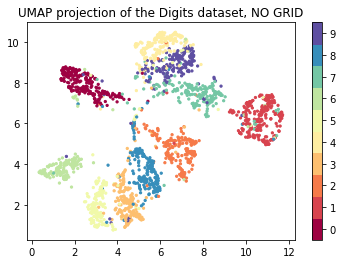

In [274]:
plt.scatter(embedding_no_grid[:, 0], embedding_no_grid[:, 1], 
            c=digits_no_grid_selected.numpy(), 
            cmap='Spectral', s=5)
plt.colorbar(boundaries=numpy.arange(11)-0.5).set_ticks(numpy.arange(10))
plt.title('UMAP projection of the Digits dataset, NO GRID', fontsize=12);
plt.savefig("./umap_no_bg.png")

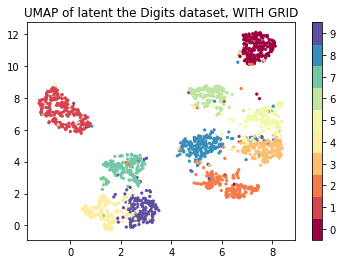

In [276]:
plt.scatter(embedding_with_grid[:, 0], embedding_with_grid[:, 1], 
            c=digits_with_grid_selected.numpy(), 
            cmap='Spectral', s=5)
plt.colorbar(boundaries=numpy.arange(11)-0.5).set_ticks(numpy.arange(10))
plt.title('UMAP of latent the Digits dataset, WITH GRID', fontsize=12);
plt.savefig("./umap_bg.png")

In [327]:
numpy.save("./umap_0", embedding_with_grid[:, 0], allow_pickle=False)
numpy.save("./umap_1", embedding_with_grid[:, 1], allow_pickle=False)
numpy.save("./labels", digits_with_grid_selected.numpy(), allow_pickle=False)

